In [1]:
import os
# Changing the working directory
os.chdir('../..')
os.getcwd()

'/home/javiermunoz/Universidad/MasterBDyDS/TFM/TFM_DSBD'

In [2]:
os.environ["TF_CPP_MIN_LOG_LEVEL"] = "3"

from tensorflow.python.util import deprecation
deprecation._PRINT_DEPRECATION_WARNINGS = False

import tensorflow as tf
gpu_devices = tf.config.experimental.list_physical_devices("GPU")
for device in gpu_devices:
    tf.config.experimental.set_memory_growth(device, True)

import matplotlib
import matplotlib.pyplot as plt
matplotlib.rc("figure", figsize=(15, 5))

import os 
from src.config import DATA_PATH, SPLITS
import pathlib
import numpy as np

/home/javiermunoz/anaconda3/envs/tf/lib/python3.9/site-packages/requests/__init__.py:109: RequestsDependencyWarning: urllib3 (1.26.15) or chardet (None)/charset_normalizer (3.1.0) doesn't match a supported version!
  warnings.warn(


In [3]:
gpu_devices

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [4]:
subset_size = 50
subset = f"subset_{subset_size}_lsa_64"
model_type = "convlstm"
model_name = "simple"

In [5]:
subset_paths = {}
for sp in SPLITS:
    subset_paths[sp] = pathlib.Path(os.path.join(DATA_PATH, subset, sp))

## 2. Loading Video Dataset

https://www.tensorflow.org/tutorials/load_data/video

In [6]:
tf.keras.backend.clear_session()  

In [7]:
from src.frame_generator import FrameGenerator
import tensorflow as tf
from src.plot_utils import plot_history

In [8]:
fg = FrameGenerator(subset_paths['train'], 10, training=True)

frames, label = next(fg())
print(f"Shape: {frames.shape}")
print(f"Label: {label}")

Shape: (10, 224, 224, 3)
Label: 10


In [9]:
n_frames = 10
batch_size = 4

# We specify the shape of the output, such as, the Generator will produce a tuple of both
# videos, class, where the videos will have 3 channels, and the rest of dimensions will remain the same.
#   VideoShape -> (F, H, W, C)
output_signature = (tf.TensorSpec(shape=(None, None, None, 3), dtype=tf.float32),
                    tf.TensorSpec(shape=(), dtype=tf.int16))

train_ds = tf.data.Dataset.from_generator(FrameGenerator(subset_paths['train'], n_frames, training=True),
                                          output_signature=output_signature)
# Also, we batchify the data, so the training process is not as memory consuming as if the whole dataset was 
# loaded into memory.
# VideoShape -> (B, F, H, W, C)
# train_ds = train_ds.batch(batch_size)
train_ds = train_ds.batch(batch_size)

# We reproduce this process for the validation and test splits too.
val_ds = tf.data.Dataset.from_generator(FrameGenerator(subset_paths['val'], n_frames),
                                        output_signature=output_signature)

val_ds = val_ds.batch(batch_size)
test_ds = tf.data.Dataset.from_generator(FrameGenerator(subset_paths['test'], n_frames),
                                         output_signature=output_signature)

test_ds = test_ds.batch(batch_size)

In [10]:
# Print the shapes of the data
train_frames, train_labels = next(iter(train_ds))
print(f'Shape of training set of frames: {train_frames.shape}')
print(f'Shape of training labels: {train_labels.shape}')

val_frames, val_labels = next(iter(val_ds))
print(f'Shape of validation set of frames: {val_frames.shape}')
print(f'Shape of validation labels: {val_labels.shape}')

Shape of training set of frames: (4, 10, 224, 224, 3)
Shape of training labels: (4,)
Shape of validation set of frames: (4, 10, 224, 224, 3)
Shape of validation labels: (4,)


In [11]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size = AUTOTUNE)
val_ds = val_ds.cache().shuffle(1000).prefetch(buffer_size = AUTOTUNE)

In [12]:
(None, *train_frames.shape[2:])

(None, 224, 224, 3)

# 3. Model definition and Training

In [13]:
model = tf.keras.Sequential([
    # Construct the input layer with no definite frame size.
    tf.keras.layers.InputLayer(input_shape=(None, *train_frames.shape[2:])),
    # Reescale the values of the pixels (per frame)
    tf.keras.layers.Rescaling(scale=255),
    # We will construct 2 `ConvLSTM2D` layers with batch normalization + a Conv2D for spacial feature extraction
    tf.keras.layers.ConvLSTM2D(
        filters=8,
        kernel_size=(3, 3),
        strides=(1,1),
        stateful=False,
        return_sequences=True,
        activation="tanh",
    ),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.ConvLSTM2D(
        filters=16,
        kernel_size=(3, 3),
        strides=(1,1),
        stateful=False,
        return_sequences=False,
        activation="tanh",
    ),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Conv2D(
        filters=16,
        kernel_size=(3,3),                       
        strides=(1,1),  
    ),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.GlobalMaxPooling2D(),
    tf.keras.layers.Dense(units=subset_size, activation='softmax')
])
model.compile(
    loss=tf.keras.losses.sparse_categorical_crossentropy, 
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-03),
    metrics=['accuracy']
)

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling (Rescaling)       (None, None, 224, 224, 3  0         
                             )                                   
                                                                 
 conv_lstm2d (ConvLSTM2D)    (None, None, 222, 222, 8  3200      
                             )                                   
                                                                 
 batch_normalization (BatchN  (None, None, 222, 222, 8  32       
 ormalization)               )                                   
                                                                 
 dropout (Dropout)           (None, None, 222, 222, 8  0         
                             )                                   
                                                                 
 conv_lstm2d_1 (ConvLSTM2D)  (None, 220, 220, 16)      1

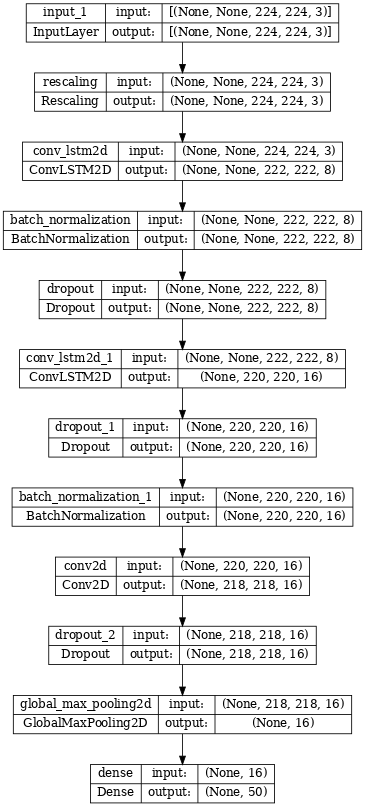

In [14]:
tf.keras.utils.plot_model(model, expand_nested=True, dpi=60, show_shapes=True)

In [15]:
# CReate a customized callback so when val_acc > 94% it stops training
from keras.callbacks import EarlyStopping, ModelCheckpoint

bst_model_path = "src/"+model_type+"/bestmodels/best_"+model_name+"_{epoch:02d}_{val_accuracy:.2f}_"+str(subset_size)+"_model.h5"

class MyThresholdCallback(tf.keras.callbacks.Callback):
    def __init__(self, threshold):
        super(MyThresholdCallback, self).__init__()
        self.threshold = threshold

    def on_epoch_end(self, epoch, logs=None): 
        val_acc = logs["accuracy"]
        if val_acc >= self.threshold:
            self.model.stop_training = True

# Define some callbacks to improve training.
early_loss_stopping = EarlyStopping(monitor="val_loss", patience=15)
early_acc_stopping = EarlyStopping(monitor="val_accuracy", patience=15)
mod_ckpoint = ModelCheckpoint(filepath = bst_model_path, 
                              save_best_only=True, 
                              monitor="val_accuracy",
                              mode="max")


callbacks=[
    #early_loss_stopping, 
    #early_acc_stopping, 
    mod_ckpoint,
    MyThresholdCallback(threshold=0.96)
]

In [16]:
# Define modifiable training hyperparameters.
epochs = 200

# Fit the model to the training data using a generator.
history = model.fit(
    train_ds,
    epochs=epochs,
    validation_data=val_ds,
    callbacks=callbacks
)

Epoch 1/200
504/504 [==============================] - 715s 476ms/step - loss: 4.2509 - accuracy: 0.0214 - val_loss: 3.9469 - val_accuracy: 0.0034
Epoch 2/200
504/504 [==============================] - 182s 362ms/step - loss: 3.9711 - accuracy: 0.0179 - val_loss: 3.8888 - val_accuracy: 0.0307
Epoch 3/200
504/504 [==============================] - 153s 304ms/step - loss: 3.9188 - accuracy: 0.0343 - val_loss: 3.9431 - val_accuracy: 0.0307
Epoch 4/200
504/504 [==============================] - 152s 302ms/step - loss: 3.8654 - accuracy: 0.0417 - val_loss: 3.7880 - val_accuracy: 0.0273
Epoch 5/200
504/504 [==============================] - 151s 299ms/step - loss: 3.6991 - accuracy: 0.0556 - val_loss: 3.6270 - val_accuracy: 0.0512
Epoch 6/200
504/504 [==============================] - 151s 299ms/step - loss: 3.4571 - accuracy: 0.0685 - val_loss: 3.3577 - val_accuracy: 0.0956
Epoch 7/200
504/504 [==============================] - 152s 301ms/step - loss: 3.2431 - accuracy: 0.0780 - val_loss: 3

In [17]:
best_model_epoch = np.argmax(history.history['val_accuracy'])
best_acc, best_loss, best_val_acc, best_val_loss = history.history['accuracy'][best_model_epoch], history.history['loss'][best_model_epoch], history.history['val_accuracy'][best_model_epoch], history.history['val_loss'][best_model_epoch]

In [18]:
best_model = tf.keras.models.load_model(f"src/{model_type}/bestmodels/best_{model_name}_{(best_model_epoch+1):02d}_{best_val_acc:.2f}_{subset_size}_model.h5")

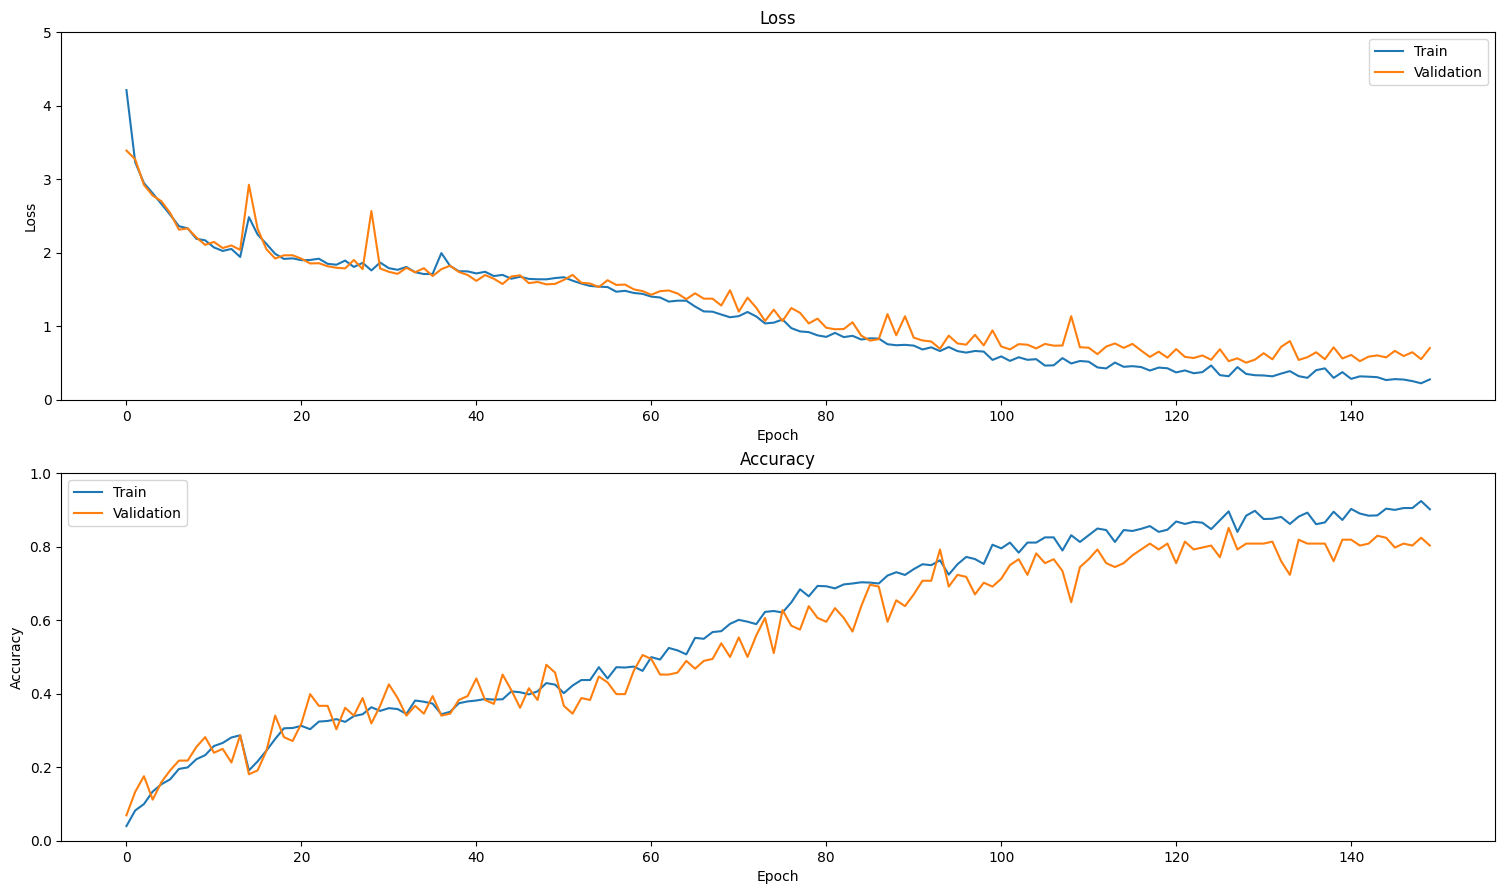

In [ ]:
plot_history(history)

In [19]:
# Evaluate the model on the test data using `evaluate`
print(f"Evaluate best model on test data with the following stats:\n\tAccuracy: {best_acc}\n\tLoss: {best_loss}\n\tVal Accuracy: {best_val_acc}\n\tVal Loss: {best_val_loss}")
test_results = best_model.evaluate(test_ds, batch_size=batch_size)
print("test loss, test acc:", test_results)

Evaluate best model on test data with the following stats:
	Accuracy: 0.7164846062660217
	Loss: 0.7961536049842834
	Val Accuracy: 0.5426621437072754
	Val Loss: 2.7827651500701904
      3/Unknown - 5s 1s/step - loss: 23.7063 - accuracy: 0.0000e+00   

: 

: 

In [ ]:
# Update leaderboard in case a new best model is found
from src.leaderboard import Leaderboard

lb = Leaderboard()
lb.update_leaderboard(history=history,
                      test_results=test_results,
                      model_name=model_name,
                      model_type=model_type,
                      subset_size=subset_size)